In [3]:
import pandas as pd

In [4]:
data = pd.read_csv('data.csv')

data.drop_duplicates(inplace=True)
data.sort_values(by=['period'], inplace=True, ascending=False)

data.to_csv('data.csv', index=False)
data.head()

,period,price,target_number,target_colour
0,20231201151,45251,1,2
1,20231201150,45253,3,2
2,20231201149,45233,3,2
3,20231201148,45214,4,1
4,20231201147,45205,5,2


In [5]:
data.drop("price", axis=1, inplace=True)

data['count_of_the_day'] = data['period'].apply(lambda x: int(str(x)[8:]))

data['period'] = data['period'].apply(lambda x: int(str(x)[0:8]))

data.head()

,period,target_number,target_colour,count_of_the_day
0,20231201,1,2,151
1,20231201,3,2,150
2,20231201,3,2,149
3,20231201,4,1,148
4,20231201,5,2,147


In [6]:
data['target_colour'] = data['target_colour'] - 1

data.head()
og_data = data.copy()


In [7]:
def get_number_colour(val):
    colour = val // 10
    number = val % 10
    return {'colour': 'green' if colour else 'red', 'number': number}

In [8]:
data['target'] = [int(str(i) + str(j)) for i, j in zip(data['target_colour'], data['target_number'])]

data.head()

,period,target_number,target_colour,count_of_the_day,target
0,20231201,1,1,151,11
1,20231201,3,1,150,13
2,20231201,3,1,149,13
3,20231201,4,0,148,4
4,20231201,5,1,147,15


In [9]:
def previous_counts(row, df):
    period = row['period']
    count_of_the_day = row['count_of_the_day']
    same_day_records = df[(df['period'] == period) & (df['count_of_the_day'] < count_of_the_day)]
    if same_day_records.empty:
        return pd.Series({'previous_50_numbers': [], 'previous_50_colours': []})
    lower_limit = max(count_of_the_day - 50, same_day_records['count_of_the_day'].min())
    prev_records = same_day_records[same_day_records['count_of_the_day'].between(lower_limit, count_of_the_day - 1)]
    return pd.Series({'previous_50_numbers': prev_records['target_number'].values, 'previous_50_colours': prev_records['target_colour'].values})

data[['previous_50_numbers', 'previous_50_colours']] = data.apply(previous_counts, axis=1, args=(data,))

data.head()

,period,target_number,target_colour,count_of_the_day,target,previous_50_numbers,previous_50_colours
0,20231201,1,1,151,11,"[3, 3, 4, 5, 9, 9, 1, 5, 4, 4, 9, 1, 7, 2, 3, ...","[1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, ..."
1,20231201,3,1,150,13,"[3, 4, 5, 9, 9, 1, 5, 4, 4, 9, 1, 7, 2, 3, 6, ...","[1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, ..."
2,20231201,3,1,149,13,"[4, 5, 9, 9, 1, 5, 4, 4, 9, 1, 7, 2, 3, 6, 2, ...","[0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, ..."
3,20231201,4,0,148,4,"[5, 9, 9, 1, 5, 4, 4, 9, 1, 7, 2, 3, 6, 2, 2, ...","[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, ..."
4,20231201,5,1,147,15,"[9, 9, 1, 5, 4, 4, 9, 1, 7, 2, 3, 6, 2, 2, 7, ...","[1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, ..."


In [10]:
data.drop(['target_colour', 'target_number'], axis=1, inplace=True)

In [11]:
def moving_average(row, df):
    period = row['period']
    count_of_the_day = row['count_of_the_day']
    same_day_records = df[(df['period'] == period) & (df['count_of_the_day'] < count_of_the_day)]
    if same_day_records.empty:
        return pd.Series({'moving_average': 0})
    lower_limit = max(count_of_the_day - 10, same_day_records['count_of_the_day'].min())
    prev_records = same_day_records[same_day_records['count_of_the_day'].between(lower_limit, count_of_the_day - 1)]
    return pd.Series({'moving_average': prev_records['target'].mean()})

data[['moving_average']] = data.apply(moving_average, axis=1, args=(data,))

data.head()

,period,count_of_the_day,target,previous_50_numbers,previous_50_colours,moving_average
0,20231201,151,11,"[3, 3, 4, 5, 9, 9, 1, 5, 4, 4, 9, 1, 7, 2, 3, ...","[1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, ...",13.625000
1,20231201,150,13,"[3, 4, 5, 9, 9, 1, 5, 4, 4, 9, 1, 7, 2, 3, 6, ...","[1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, ...",13.714286
2,20231201,149,13,"[4, 5, 9, 9, 1, 5, 4, 4, 9, 1, 7, 2, 3, 6, 2, ...","[0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, ...",13.833333
3,20231201,148,4,"[5, 9, 9, 1, 5, 4, 4, 9, 1, 7, 2, 3, 6, 2, 2, ...","[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, ...",15.800000
4,20231201,147,15,"[9, 9, 1, 5, 4, 4, 9, 1, 7, 2, 3, 6, 2, 2, 7, ...","[1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, ...",16.000000


In [12]:
data.describe()

,period,count_of_the_day,target,moving_average
count,6.835000e+03,6835.000000,6835.000000,6792.000000
mean,2.023112e+07,238.316020,9.808632,9.776822
std,1.158371e+01,137.656895,5.890620,2.123155
min,2.023111e+07,1.000000,0.000000,0.000000
25%,2.023112e+07,119.000000,4.000000,8.500000
50%,2.023112e+07,238.000000,8.000000,9.800000
75%,2.023113e+07,357.000000,15.000000,11.200000
max,2.023120e+07,480.000000,19.000000,19.000000


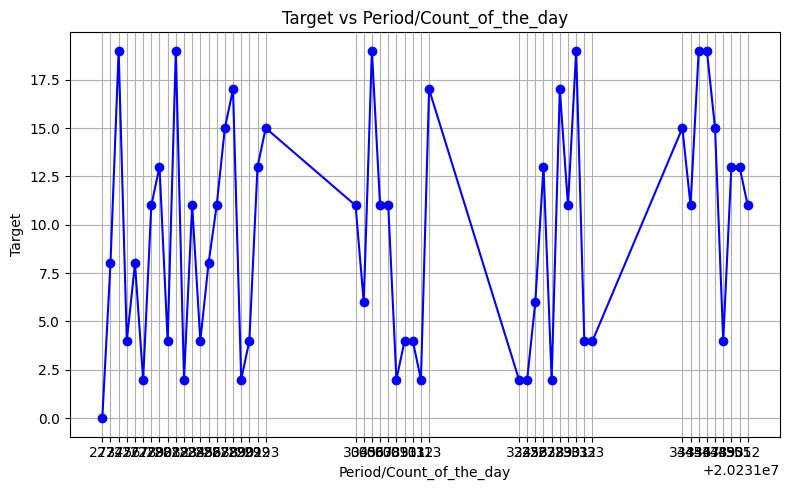

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(data['period'][:50] + data['count_of_the_day'][:50] , data['target'][:50] , marker='o', linestyle='-', color='blue')
plt.title('Target vs Period/Count_of_the_day')
plt.xlabel('Period/Count_of_the_day')
plt.ylabel('Target')
plt.grid(True)
plt.xticks(data['period'][:50]  + data['count_of_the_day'][:50] )
plt.tight_layout()

plt.show()

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Masking, Bidirectional, LSTM, Dense, concatenate, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np

In [15]:
data['previous_50_numbers'] = data['previous_50_numbers'].apply(lambda x: np.array(x))
data['previous_50_colours'] = data['previous_50_colours'].apply(lambda x: np.array(x))

In [16]:
data['moving_average'][np.isnan(data['moving_average'])] = -1

<ipython-input-16-b918cde4d3e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['moving_average'][np.isnan(data['moving_average'])] = -1


In [17]:
X_numbers = pad_sequences(data['previous_50_numbers'], maxlen=50, padding='pre', value=-1)
X_colours = pad_sequences(data['previous_50_colours'], maxlen=50, padding='pre', value=-1)

# X_period_count = data[['period', 'count_of_the_day']].values
X_period_count = data[['count_of_the_day']].values

X_moving_average = data[['moving_average']].values

In [18]:
# y_number = data['target_number']
# y_colour = data['target_colour']

# num_classes_number = len(np.unique(y_number))
# num_classes_colour = len(np.unique(y_colour))

# y_encoded_number = to_categorical(y_number, num_classes=num_classes_number, dtype="int32")
# y_encoded_colour = to_categorical(y_colour, num_classes=num_classes_colour, dtype="int32")

In [19]:
y = to_categorical(data['target'], num_classes=20, dtype="int32")


In [20]:
print(X_numbers[:2], X_colours[:2], X_period_count[:2], y[:2])

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  3  3
   4  5  9  9  1  5  4  4  9  1  7  2  3  6  2  2  7  2  4  4  2  1  1  9
   6  1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  3
   4  5  9  9  1  5  4  4  9  1  7  2  3  6  2  2  7  2  4  4  2  1  1  9
   6  1]] [[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1
   0  1  1  1  1  1  0  0  1  1  1  0  1  0  0  0  1  0  0  0  0  1  1  1
   0  1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1
   0  1  1  1  1  1  0  0  1  1  1  0  1  0  0  0  1  0  0  0  0  1  1  1
   0  1]] [[151]
 [150]] [[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]


In [21]:
# RNN model

# input layers
input_numbers = Input(shape=(50, 1))
input_colours = Input(shape=(50, 1))
input_period_count = Input(shape=(1,))
input_moving_average = Input(shape=(1,))

# Apply Masking layers
masked_numbers = Masking(mask_value=-1)(input_numbers)
masked_colours = Masking(mask_value=-1)(input_colours)
masked_moving_average = Masking(mask_value=-1)(input_moving_average)

# LSTM layers
lstm_numbers = Bidirectional(LSTM(128, return_sequences=True))(masked_numbers)
lstm_colours = Bidirectional(LSTM(128, return_sequences=True))(masked_colours)

# Flatten LSTM outputs
lstm_numbers_flat = Flatten()(lstm_numbers)
lstm_colours_flat = Flatten()(lstm_colours)

# Concatenate all processed inputs
concatenated_layers = concatenate([lstm_numbers_flat, lstm_colours_flat, input_period_count, masked_moving_average])

# Dense layers
dense = Dense(64, activation='relu')(concatenated_layers)
dropout = Dropout(0.5)(dense)
dense = Dense(64, activation='elu')(dropout)
batch = BatchNormalization()(dense)
dense = Dense(64, activation='relu')(batch)
output = Dense(20, activation='softmax')(dense)

# Create the model
model = Model(inputs=[input_numbers, input_colours, input_period_count, input_moving_average], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [22]:
history = model.fit([X_numbers, X_colours, X_period_count, X_moving_average],  y, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping]) # [y_encoded_number, y_encoded_colour]

Epoch 1/100
114/171 [===================>..........] - ETA: 25s - loss: 2.6409 - accuracy: 0.0998

KeyboardInterrupt: ignored

In [ ]:
model.summary()
model.save('rnn_model.h5')

In [ ]:
def get_previous_records(period, count_of_the_day, df):
    same_day_records = df[(df['period'] == period) & (df['count_of_the_day'] < count_of_the_day)]
    if same_day_records.empty:
        return [], []
    lower_limit = max(count_of_the_day - 50, same_day_records['count_of_the_day'].min())
    prev_records = same_day_records[same_day_records['count_of_the_day'].between(lower_limit, count_of_the_day - 1)]
    return prev_records['target_number'].values, prev_records['target_colour'].values

def predictor(model, value):
    period = int(value[:8])
    count_of_the_day = int(value[8:])

    # period_count = np.array([period, count_of_the_day]).reshape(1, -1)
    period_count = np.array([count_of_the_day]).reshape(1, -1)

    previous_numbers, previous_colours = get_previous_records(period, count_of_the_day, og_data)

    previous_numbers = pad_sequences([previous_numbers], maxlen=50, padding='pre', value=-1)
    previous_colours = pad_sequences([previous_colours], maxlen=50, padding='pre', value=-1)

    print(period_count, previous_numbers, previous_colours)

    predicted_val = model.predict([previous_numbers, previous_colours, period_count])

    return get_number_colour(np.argmax(predicted_val))

predictor(model, '20231127145')